Corpus Analytics
==============

Now that we've overviewed all the steps involved in preparing text for computational analysis, we can begin the 
work of analysis proper. Whereas the last chapter suggested a few ways we might do this with a single novel, this 
one will build out to a whole collection of texts, or what's called a **corpus**. Computational analysis can help 
us discover many interesting things about a single text, but looking at this text in the context of many others 
will do much to clarify and expand any potential findings we might make. Accordingly, we'll learn how to implement 
our cleaning steps on multiple files and then format them in a way that enables us to make connections between 
them. We'll then generate several metrics about these texts and use them to observe similarities/differences across 
the corpus.

We'll also leave _Frankenstein_ behind, at least for now. In place of this novel, we will use Andrew Piper's 
[collection of English short stories](https://doi.org/10.6084/m9.figshare.17425571.v1), which gathers together 50 
stories from 1981 to 2006. **UNCLEAR WHETHER WE'LL ULTIMATELY USE THIS ONE---PLUGGING IT IN TO OUTLINE THE 
CHAPTER.**

```{admonition} Learning Objectives
By the end of this workshop, you will be able to:

+ Develop a workflow for cleaning multiple texts and compiling them into a corpus
+ Use a document-term matrix, to represent relationships between texts in a corpus
+ Generate metrics about texts in a corpus, including document length, term frequency, lexical diversity, etc.
+ Explain the difference between raw term metrics and weighted term scoring (specifically, TF-IDF scoring)
+ Cluster texts according to their shared/similar features
```

The Data
-----------

Before we begin cleaning, we'll load in a file manifest to get a quick overview of what will be in our corpus. 
We'll also use this manifest to sequentially load each file, clean it, and add it to our corpus.

Number of stories: 50 
Number of authors: 50 
Columns in the manifest: ['NAME' 'TITLE' 'YEAR' 'FILE_NAME']


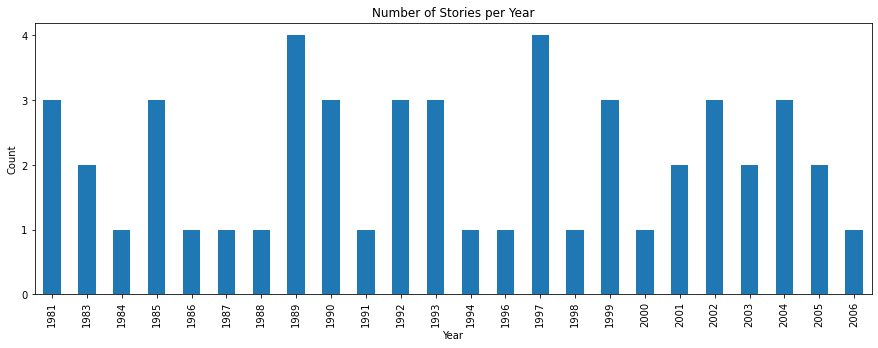

In [1]:
import pandas as pd

indir =  "data/session_two/"
manifest = pd.read_csv(indir + "manifest.csv", index_col=0)

print(
    "Number of stories:", len(manifest),
    "\nNumber of authors:", manifest['NAME'].nunique(),
    "\nColumns in the manifest:", manifest.columns.values
)
manifest.groupby('YEAR')['TITLE'].count().plot.bar(figsize = (15,5),
                                                   title = "Number of Stories per Year",
                                                   xlabel = "Year",
                                                   ylabel = "Count",
                                                   yticks = range(0,5)
                                                  );

Here are a few story titles, selected at random:

In [2]:
for idx in manifest.sample(5).index:
    print(f"{manifest.loc[idx, 'NAME']}:", manifest.loc[idx, 'TITLE'])

JONES, Edward P.: Marie
ORRINGER, Julie: Pilgrims
O’BRIEN, Tim: TheThingsTheyCarried
DOERR, Anthony: TheCaretaker
YARBROUGH, Steve: TheRestofHerLife


Text Cleaning
----------------

### Recap

With that done, we can review our cleaning steps. For each short story in our corpus, we want to:

1. Resolve casing
2. Remove punctuation, numbers, and any extra formatting
3. Remove stop words

```{margin} Note:
For this analysis, we won't stem or lemmatize our tokens, but below we'll make note of where doing so might be 
useful.
```

This should feel familiar, though our workflow here will differ slightly from the one in the last chapter because 
we'll be cleaning multiple texts, not only one. All the principles remain the same, we just want to implement our 
cleaning steps in a way that successively works through every text in our data directory without much intervention 
on our part. This is where functions are helpful; we'll define a series of them. Each one will perform a separate 
step in the cleaning process. We'll also define a main function, `clean()`, which we'll use to control each 
function in the series. That way, we can simply load in a text file and pass it to `clean()` and `clean()` will 
handle the rest.

### Defining our text cleaning functions

`clean()` will call the following five functions:

1. `to_lower()`: a simple function that returns a lowercase version of all tokens in a text
2. `remove_punctuation()`: removes all punctuation, doing so in phases: hyphens, em dashes, and underscores 
first, then everything else
3. `remove_digits()`: removes digits
4. `tokenize()`: removes any extra whitespace and returns a list of all tokens in a text
5. `remove_stop_words()`: filters out stop words from the list of tokens; we'll also remove any words that are two 
or less characters long

Let's get coding!

In [3]:
import re

with open("data/voyant_stoplist.txt", 'r') as f:
    stopwords = f.read().split()

def to_lower(doc):
    return doc.lower()

def remove_punctuation(doc):
    doc = re.sub(r"[-]|[—]|[_]", " ", doc)
    doc = re.sub(r"[^\w\s]", "", doc)
    return doc

def remove_digits(doc):
    return re.sub(r"[0-9]", "", doc)

def tokenize(doc):
    doc = re.sub(r"\s+", " ", doc)
    return doc.split()

def remove_stop_words(doc):
    doc = [token for token in doc if token not in stopwords]
    doc = [token for token in doc if len(token) > 2]
    return doc

def clean(doc):
    lowercase = to_lower(doc)
    no_punct = remove_punctuation(lowercase)
    no_digits = remove_digits(no_punct)
    tokenized = tokenize(no_digits)
    stopped = remove_stop_words(tokenized)
    return stopped

```{admonition} About the above...
These functions are written with **clarity** and **modularity** in mind. The intent here is to demonstrate each 
step of the cleaning process in as discrete a manner as possible. But you might find that some of this code is 
redundant (as an example, ask yourself: which step might be wrapped up inside another function?). Further, we could 
very probably re-factor this code to optimize it, which would be important when working with a large number of 
texts. We won't cover something like that in this session however. For now, know that these functions are meant to 
act as templates, which you can modify to suit your own needs.
```

### Cleaning our texts

With our functions defined, we can now load each story, roll through all the cleaning steps, and append the cleaned 
text to a list. The result will be a fifty-item list of lists, where each sublist contains all the tokens in a 
given story. The _order_ of these entries will be important for work want to do later on, so we need to make sure 
that each sublist always has the same position in the larger list of texts. This is where the file manifest comes 
in: _we'll load texts in the order provided by the `FILE_NAME` column of `manifest`_. Doing so ensures that the 
first index (`0`) of our list of lists corresponds to the first short story, the second index (`1`) to the second, 
and so on.

Let's write all this out in a `for` loop and do our cleaning.

```{margin} What this loop does:
1. For every row (`idx`) in `manifest`, collect the item in the row's `FILE_NAME` column and append it to `indir`
2. Use the resultant filepath in a `with...open` statement to read in the text
3. Clean the story with `clean()`
4. Append the result to the list, `cleaned_stories`
```

In [4]:
cleaned_stories = []

for idx in manifest.index:
    filepath = indir + manifest.loc[idx, 'FILE_NAME']
    with open(filepath, 'r') as f:
        story = f.read()
        cleaned_story = clean(story)
        cleaned_stories.append(cleaned_story)

As a sanity check, we can run an assertion statement, which checks that `cleaned_stories` has as many stories in it 
as `manifest` does...

In [5]:
assert len(cleaned_stories) == len(manifest)

...and we can inspect a few pieces of some stories to make sure all is well:

In [6]:
for idx in [4, 17, 39]:
    fragment = cleaned_stories[idx][10:21]
    print(' '.join(fragment))

behind card table outside food minutes sun shifts moves chair table
barbie away ken practicing future sat sisters room watching barbie lived
silver clouds floating horizon robins sparrows calling trees son joshuas seventh


Looks great!